In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import argparse
import datetime

import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind
from backtrader.indicators import PeriodN
import backtrader.analyzers as btanalyzers
import numpy as np
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import time
import math
import seaborn as sns

In [2]:
directory = ""

If [ not in market ]

Then

/ search for long opportunity

	If hurst_exponent, abs(zscore)^hurst exponent > threshold and beta in sensible range
    
	Then
    
    long/short spread zscore is +/-
		
Else (in market, already long spread)

// search for signal to close position

	If beta <0 hurst_exponent < threshold , or loss> some or  % 
    or abs(zscore)^hurst exponent > threshold in opposite direction
    
	Then
    
		Close spread position

In [3]:
def tls(p0, p1):
    #replaced by multi_tls for faster computation on multiple pairs
    x = np.log(p0/p0[0])
    y = np.log(p1/p1[0])
    c0 = np.sum((x - np.mean(x))*(y - np.mean(y)))
    c1 = np.sum((x - np.mean(x))**2 - (y - np.mean(y))**2)
    b1 = np.array([(-c1+np.sqrt(c1**2+4*c0*c0))/2/c0, (-c1-np.sqrt(c1**2+4*c0*c0))/2/c0])
    b0 = -b1*np.mean(x)+np.mean(y)
    res0 = (y - b1[0]*x-b0[0])/np.sqrt(1+b1[0]**2)
    res1 = (y - b1[1]*x-b0[1])/np.sqrt(1+b1[1]**2)
    if np.sum(res0**2) <  np.sum(res1**2):
        return b0[0], b1[0], res0, np.sum(res0**2)
    else:
        return b0[1], b1[1], res1, np.sum(res1**2)
    
def multi_tls(p):
    #take a list of np.array as input, perform tls for any pairs of array
    #return a dictionary
    #key is the index of the array in the list
    #each value is a tuple: (intercept, beta, array of residuals, sum of residuals square)
    norm = [np.log(p0/p0[0]) for p0 in p]
    sx = [x0-np.mean(x0) for x0 in norm]
    sxx =[ np.sum(x0 ** 2) for x0 in sx]
    n = len(p)
    d = {}
    for i in range(n):
        for j in range(i+1, n):
            c0 = np.sum(sx[j]*sx[i])
            c1 = sxx[i]-sxx[j]
            x = norm[i]
            y =  norm[j]
            b1 = np.array([(-c1+np.sqrt(c1**2+4*c0*c0))/2/c0, (-c1-np.sqrt(c1**2+4*c0*c0))/2/c0])
            b0 = -b1*np.mean(x)+np.mean(y)
            res0 = (y - b1[0]*x-b0[0])/np.sqrt(1+b1[0]**2)
            res1 = (y - b1[1]*x-b0[1])/np.sqrt(1+b1[1]**2)
            if np.sum(res0**2) <  np.sum(res1**2):
                d[(i,j)] = (b0[0], b1[0], res0, np.sum(res0**2))
            else:
                d[(i,j)] =( b0[1], b1[1], res1, np.sum(res1**2))
    return d

def hurst_exponent(series, kind = 'random_walk',min_window = 10, max_window = None):
    #with reference to https://github.com/Mottl/hurst#egg=hurst
    #take np.array as input
    def get_rs(x, kind = 'random_walk'):
        if kind == 'random_walk':
            diff = x[1:]-x[:-1]
            R = max(x) - min(x)  # range in absolute values
            S = np.std(diff, ddof=1)
        elif kind == 'change':
            diff = x
            _x = np.hstack([[0.],np.cumsum(diff)])
            R = max(_x) - min(_x)  # range in absolute values
            S = np.std(diff, ddof=1)

        if S == 0:
            return 0  # return 0 to skip this interval due the undefined R/S ratio

        return R / S
    
    
    err = np.geterr()
    np.seterr(all='raise')
    
    max_window = max_window or len(series)-1
    window_sizes = list(map(
        lambda x: int(10**x),
        np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
    window_sizes.append(len(series))

    RS = []
    
    for w in window_sizes:
        rs = []
        for start in range(0, len(series), w):
            if (start+w)>len(series):
                break
            tem = get_rs(series[start:start+w], kind = kind)
            if tem != 0:
                rs.append(tem)
        RS.append(np.mean(rs))

    A = np.vstack([np.log10(window_sizes), np.ones(len(RS))]).T
    H, c = np.linalg.lstsq(A, np.log10(RS), rcond=-1)[0]
    np.seterr(**err)

    c = 10**c
    return H, c, [window_sizes, RS]

In [4]:
# Class to support feeding self-defined data structure
class DataFeeder(bt.feeds.GenericCSVData):
    
    lines = ('daily_interest_rate',)
    
    params = (
        ('dtformat', ('%Y-%m-%d')),
        ('datetime', 0),
        ('time', -1),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 5),
        ('daily_interest_rate', 6),
        ('openinterest', -1)
    )

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as mtick
munits.registry[np.datetime64] = mdates.ConciseDateConverter()

# Class to aggregate/analyze/plot the backtest result
class Evaluator():
    def __init__(self, symbols=None, trade=None, annual_return=None, pos_dict=None,
                 transactions=None, strats=None, **kwargs):
        self.symbols = symbols
        self.trade = trade
        self.annual_return = annual_return
        self.pos_dict = pos_dict
        self.transactions = transactions
        self.strats = strats
        self.kwargs = kwargs
        
        nav_df = self.posdict_to_nav(pos_dict, symbols, strats[0].first_day)
        self.nav_df, self.summary = self.evaluation_df(nav_df)
        
        volume = transactions['value'].abs().groupby(transactions.index).sum()
        volume.index = volume.index.date
        self.nav_df['Volume'] = volume
        self.trade_summary_df = self.pair_trade_analysis(strats[0].spread_profit, symbols)
        self.summary['Avg 30-d Trading Volume'] = volume.sum()/len(self.nav_df)*30
        
    def show_summary(self):
        print(pd.DataFrame(self.summary.values(), index=self.summary.keys(), columns=['']))
        
        fig = plt.figure(figsize=[7.2, 6.3])
        ax0 = plt.subplot2grid((5,1), (0,0), rowspan=3, fig=fig)
        ax1 = plt.subplot2grid((5,1), (3,0), rowspan=1, fig=fig, sharex=ax0)
        ax2 = plt.subplot2grid((5,1), (4,0), rowspan=1, fig=fig, sharex=ax0)
        fig.subplots_adjust(hspace=0)

        ax0.plot(self.nav_df['Nav'])
        ax0t = ax0.twinx()
        ax0t.yaxis.set_major_formatter(mtick.PercentFormatter())
        exposure_pct = self.nav_df['Exposure'] / self.nav_df['Nav'] * 100
        ax0t.fill_between(self.nav_df.index, exposure_pct, alpha = 0.2)
        exposure_max = exposure_pct.max()
        ax0t.set_ylim(0, exposure_max * 2)
        ax0t.set_yticks([exposure_max])
        ax0.set_ylabel('NAV', fontsize=12)
        ax0t.set_ylabel('Exposure', fontsize=12)
        ax0.set_title('NAV', fontsize=15)
        plt.setp(ax0.get_xticklabels(), visible=False)
        
        ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
        drawdown_pct = -self.nav_df['Drawdown'] * 100
        ax1.fill_between(self.nav_df.index, drawdown_pct, alpha=0.5, facecolor='red')
        drawdown_min = drawdown_pct.min()
        ax1.set_ylim(drawdown_min*1.2, 0)
        ax1.yaxis.set_label_position("right")
        ax1.yaxis.tick_right()
        ax1.set_yticks([0, drawdown_min])
        ax1.set_ylabel('Drawdown', fontsize=11)
        plt.setp(ax1.get_xticklabels(), visible=False)
        
        ax2.fill_between(self.nav_df.index, self.nav_df['Volume'], color='#A9D08E')
        ax2.set_ylabel('Trade volume', fontsize=11)
        ax2.set_ylim(0)
        
        plt.show()
    
    def show_position_vs_price(self):
        for i in self.symbols:
            fig = plt.figure()

            ax1 = fig.add_subplot(111)
            ax2 = ax1.twinx()
            tem_df = pd.read_csv(directory+"Binance_"+i+"_d_with_interest.csv", index_col = 0)
            new_df = pd.merge(tem_df[['close']], self.nav_df[[i]], left_index = True, right_index = True)
            ax2.plot(new_df['close'], color = 'orange')
            ax1.plot(new_df[i])
            ax1.set_title(i)
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Net Position')
            ax2.set_ylabel('Price')
            plt.show()
    
    
    def show_position(self):
        n = len(self.symbols)
        fig = plt.figure(figsize=[7.2, 1.4*(n+3)])
        fig.subplots_adjust(hspace=0)
        
        ax0 = plt.subplot2grid((n+3,1), (0,0), rowspan=3, fig=fig)   
        ax0.plot(self.nav_df['Nav'])
        ax0t = ax0.twinx()
        ax0t.yaxis.set_major_formatter(mtick.PercentFormatter())
        exposure_pct = self.nav_df['Exposure'] / self.nav_df['Nav'] * 100
        ax0t.fill_between(self.nav_df.index, exposure_pct, alpha = 0.2)
        exposure_max = exposure_pct.max()
        ax0t.set_ylim(0, exposure_max * 2)
        ax0t.set_yticks([exposure_max])
        ax0.set_ylabel('NAV', fontsize=12)
        ax0t.set_ylabel('Exposure', fontsize=12)
        ax0.set_title('Position as percentage of NAV', fontsize=15)
        plt.setp(ax0.get_xticklabels(), visible=False)

        palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
        color_n = len(palette) - 1
        color_i = 0
        p_max = 0
        p_min = 0
        axs = []

        for i in range(n):
            color_i = color_i + 1 if color_i < color_n else 0
            ax = plt.subplot2grid((n+3,1), (3+i,0), rowspan=1, fig=fig, sharex=ax0)
            ax.yaxis.set_major_formatter(mtick.PercentFormatter())

            position_pct = self.nav_df[self.symbols[i]] / self.nav_df['Nav'] * 100
            ax.plot(position_pct, color=palette[color_i])
            ax.set_ylabel(self.symbols[i], fontsize=12)
            position_max = position_pct.max()
            position_min = position_pct.min()
            ax.yaxis.tick_right()
            ax.set_yticks([position_min, position_max])
        #     ax.set_yticks([0], minor=True)
        #     ax.yaxis.grid(True, which='minor')
            ax.axhline(0, linewidth = 1, alpha=0.5)
            
            if position_max > p_max:
                p_max = position_max
            if position_min < p_min:
                p_min = position_min
            axs.append(ax)

            if i != n - 1:
                plt.setp(ax.get_xticklabels(), visible=False)
        
        # Set a same scale for all position plots
        for ax in axs:
            ax.set_ylim(p_min * 1.2, p_max * 1.2)
            
        plt.show()
            
    def posdict_to_nav(self, pos_dict, symbols, first_day = None):
        pos = pd.DataFrame(pos_dict).transpose()
        pos.index = pd.to_datetime(pos.index)
        if first_day!=None:
            pos = pos[pos.index>=datetime.datetime(first_day.year,first_day.month,first_day.day)]
        pos.columns = symbols + ['Cash']
        pos['Nav'] = pos['Cash']
        pos['Exposure'] = 0
        for col in symbols:
            pos['Nav']+=pos[col]
            pos['Exposure']+=np.abs(pos[col])
        return pos
    
    def pair_trade_analysis(self, d,c):
        df = pd.DataFrame()
        for key in d:
            no = 0
            profit = 0
            days = 0
            s_date = 0
            for s in d[key]:
                if len(s)==2:
                    profit+=s[1]*100
                    no+=1
                    days+=(s[0]-s_date).days
                else:
                    s_date = s[0]
            df = df.append({'Pair': c[key[0]]+' '+c[key[1]], 'Number of Trades':no,'Avg Profit (Before trading costs) (in %)':  profit/no, 'Avg Holding Period (Days)':days/no},ignore_index = True)
        return df.set_index('Pair')[['Number of Trades','Avg Profit (Before trading costs) (in %)', 'Avg Holding Period (Days)']]
    
    def evaluation_df(self, df, days = 365, rf = 0):
        n = len(df)-1
        days_between = (df.index[-1] - df.index[0]).days
        nav_df = df.copy()
        nav_df['Free_cash'] = nav_df['Nav']-nav_df['Exposure']
        nav_df['Return'] = nav_df['Nav'].pct_change()
        nav_df['Moneydown'] = nav_df['Nav'].rolling(window = n, min_periods = 0).max() - nav_df['Nav']
        nav_df['Drawdown'] = 1-nav_df['Nav']/nav_df['Nav'].rolling(window = n, min_periods = 0).max()
        vol = nav_df['Return'].std()*np.sqrt(days)
        ret = (nav_df['Nav'][-1]/nav_df['Nav'][0])**(365/days_between)-1
        neg_vol = nav_df[nav_df['Return']<0]['Return'].std()*np.sqrt(days)
        sharpe = (ret-rf)/vol
        sortino = (ret-rf)/neg_vol
        mmd = max(nav_df['Moneydown'])
        mdd = max(nav_df['Drawdown'])
        calmar = ret / mdd
        var99 = -np.quantile(nav_df['Return'].dropna(),0.01)
        cvar99 = -np.mean(np.sort(nav_df['Return'].dropna())[:n//100])
        res = {'Days': n,
               'Cumulative Return':nav_df['Nav'][-1]/nav_df['Nav'][0]-1,
               'Annualized (Geometric) Return':ret, 
               'Annual Volatility': vol, 
               'Sharpe Ratio':sharpe, 
               'Maximum Drawdown':mdd,
               'Maximum Moneydown':mmd,
               'Calmar Ratio':calmar,
               'Sortino Ratio':sortino,
               '99% Daily VaR': var99,
               '99% Daily CVaR': cvar99
              }
        return nav_df, res

In [6]:
class CommInfo_Crypto(bt.CommInfoBase):
    params = (
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        ('percabs', True),
    )

    def getsize(self, price, cash):
        return self.p.leverage * (cash / price)
    
    # Dynamic interest rates
    def _get_credit_interest(self, data, size, price, days, dt0, dt1):
        
        #use custom short interest in case of missing data
        if np.isnan(data.daily_interest_rate[0]):
            return abs(size) * price * (self.p.interest / 365.0)
        
        return abs(size) * price * (data.daily_interest_rate[0])
    
    
class PairTrading(bt.Strategy):
    params = (
        ('printlog', False),
        ('pct',1),
        ('spread_period',50),
        ('hurst_window', 30),
        ('hurst_exit_threshold',0.4),
        ('hurst_min',0.55),
        ('power_stat',1.5),
        ('cut_loss',-0.15),
        ('beta_max',10),
        ('beta_min',0.1)
    )
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        if self.params.printlog:
            dt = self.datas[0].datetime.datetime(0)
            print('%s, %s' % (dt.strftime("%Y-%m-%d"), txt))
    
    def __init__(self):
        # To keep record
        self.first_day = None
        
        #record no. of opened order for each coin
        self.order = {}
        
        #record no. of opened order for each coin this day
        self.order_curround = {}
        
        #record the abs(shares) of each crypto pair
        #each value is a tuple
        self.spread_position = {}
        
        #record status of each crypto pair 
        #1: long, -1:short, 0: 0
        self.status = {}
        
        #price when we open the position (before cost)
        #each value is a tuple
        self.spread_cost = {}
        
        
        #record date of opening and closing the opsition of a pair, and profit of the trade
        #each value is a list:[(open date), (close date, pnl), (open date), (close date, pnl), ...]
        self.spread_profit = {}
        
        #initialize
        for i in range(len(self.datas)):
            self.order[self.datas[i]] = 0
            self.order_curround[self.datas[i]] = 0
            for j in range(i+1, len(self.datas)):
                self.status[(i,j)] = 0
                self.spread_position[(i,j)] = (0,0)
                self.spread_cost[(i,j)] = (0,0)
                self.spread_profit[(i,j)] = []
            
            
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            #self.log('Order Submitted/Accepted')
            return
        dn = order.data._name
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY %s EXECUTED, %.2f, %2f' % (dn, order.executed.price, order.executed.size))
                self.order[order.data]-=1
            elif order.issell():
                self.log('SELL %s EXECUTED, %.2f, %2f' % (dn, order.executed.price, order.executed.size))
                self.order[order.data]-=1
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            self.order[order.data]-=1


        
    def next(self):

        order_pct = self.p.pct/len(self.datas)/(len(self.datas)-1)
        
        for i, d in enumerate(self.datas):
            pos = self.getposition(d).size
            self.log('%s: POS %f, CLOSE %.2f' % (d._name, pos, d.close[0]))
            #set number of opened orders this day back to 0
            self.order_curround[self.datas[i]] = 0
        
        #list of days of data for each data feed
        days = [len(d0) for d0 in self.datas]
        
        #check if we have enough data for each data feed
        if (min(days) > self.p.spread_period):
            #record the first day we have enough data
            self.first_day = self.first_day or self.datas[0].datetime.date(0)
            nav = self.broker.getvalue()
            #perform tls for crypto pair
            ds = [np.array(d0.close.get(ago=0, size=self.p.spread_period)) for d0 in self.datas]
            ovr_res = multi_tls(ds)
                
            for i in range(len(self.datas)):
                for j in range(i+1, len(self.datas)):
                    #for each crypto pair
                    d0 = self.datas[i]
                    d1 = self.datas[j]
                    #self.log("%s %f %f %s %f %f" %(d0._name, self.order[self.datas[i]],self.order_curround[self.datas[i]], d1._name, self.order[self.datas[j]],self.order_curround[self.datas[j]]))
                    if self.order[self.datas[i]]>self.order_curround[self.datas[i]]  or self.order[self.datas[j]]>self.order_curround[self.datas[j]] :
                        #ie. number open order = 3, number of orders opened today is 2
                        #means order from yesterday is not cleared
                        continue
                    res = ovr_res[(i,j)]
                    spread = res[2]
                    beta = res[1]
                    zscore = (spread[-1] - np.mean(spread))/np.std(spread)
                    hurst = hurst_exponent(spread, max_window = self.p.hurst_window)[0]
                    self.log('%s %s: Hurst %f, Spread %f, Zscore %f, Beta %f' % (d0._name, d1._name, hurst, spread[-1], zscore, beta))
                    if self.status[(i,j)] == 0 and beta >self.p.beta_min and beta <self.p.beta_max:
                        if hurst > self.p.hurst_min and np.abs(zscore) ** hurst > self.p.power_stat:
                            x_size = nav * order_pct / d0.close[0]*2*beta/(1+beta)
                            y_size = nav * order_pct / d1.close[0]*2/(1+beta)
                            if zscore < 0:
                                self.buy(data=d0, size = x_size, exectype=bt.Order.Market)
                                self.sell(data=d1, size = y_size, exectype=bt.Order.Market)
                                self.log('BUY %s, %.2f' % (d0._name, d0.close[0]))
                                self.log('SELL %s, %.2f' % (d1._name, d1.close[0]))
                                self.status[(i,j)] = -1 #short the spread
                            else:
                                self.sell(data=d0, size = x_size, exectype=bt.Order.Market)
                                self.buy(data=d1, size = y_size, exectype=bt.Order.Market)
                                self.log('SELL %s, %.2f' % (d0._name, d0.close[0]))
                                self.log('BUY %s, %.2f' % (d1._name, d1.close[0]))
                                self.status[(i,j)] = 1 #long the spread
                                
                            #increase the number of open orders
                            self.order[d0] += 1
                            self.order[d1] += 1
                            self.order_curround[d0] +=1
                            self.order_curround[d1] +=1
                            #record the abs shares and cost
                            self.spread_position[(i,j)] = (x_size, y_size)
                            self.spread_cost[(i,j)] = (d0.close[0], d1.close[0])
                            #record the date
                            self.spread_profit[(i,j)].append(tuple([self.datas[0].datetime.date(0)]))
                            
                    elif self.status[(i,j)] != 0:
                        cost = self.spread_cost[(i,j)]
                        pos = self.spread_position[(i,j)]
                        profit = -self.status[(i,j)]* (pos[0]*(d0.close[0]-cost[0]) - pos[1]*(d1.close[0]-cost[1]))/(pos[0]*cost[0]+pos[1]*cost[1])
                        self.log('%s %s: Profit %f Cost:%f %f' % (d0._name, d1._name, profit, cost[0], cost[1]))
                        if hurst< self.p.hurst_exit_threshold or profit < self.p.cut_loss or beta < 0 or np.sign(zscore)*np.abs(zscore) ** hurst *self.status[(i,j)] < -self.p.power_stat:
                            if self.status[(i,j)] == -1:
                                self.sell(data = d0, size = pos[0],exectype=bt.Order.Market)
                                self.buy(data = d1, size = pos[1],exectype=bt.Order.Market)
                                self.log('CLOSE SELL %s, %.2f' % (d0._name, d0.close[0]))
                                self.log('CLOSE BUY %s, %.2f' % (d1._name, d1.close[0]))
                            else:
                                self.buy(data = d0, size = pos[0],exectype=bt.Order.Market)
                                self.sell(data = d1, size = pos[1],exectype=bt.Order.Market)
                                self.log('CLOSE BUY %s, %.2f' % (d0._name, d0.close[0]))
                                self.log('CLOSE SELL %s, %.2f' % (d1._name, d1.close[0]))

                            self.status[(i,j)] = 0
                            #increase the number of open orders
                            self.order[d0] += 1
                            self.order[d1] += 1
                            self.order_curround[d0] +=1
                            self.order_curround[d1] +=1
                            #record the abs shares
                            self.spread_position[(i,j)] = (0,0)
                            #record the date and pnl
                            self.spread_profit[(i,j)].append((self.datas[0].datetime.date(0), profit))

                            
    def stop(self):             
        print(f"FIRST DAY: {self.first_day}")
        print("START VALUE: %.2f" % self.broker.startingcash)
        print("END VALUE: %.2f" % self.broker.getvalue())
        return

In [7]:
def runstrategy(c, hurst_exit_threshold = 0.4,
                hurst_min = 0.55,
                power_stat = 1.5,
                start_value = 10**7,
                commission = 0.0006, 
                interest = 0.1, 
                #interest to be used when daily short interest data is missing
                #0.1 : 10 % per annum
                slip_perc = 0.002):
    cerebro = bt.Cerebro()
    
    for coin0 in c:
        cerebro.adddata(DataFeeder(dataname=directory+"Binance_"+coin0+"_d_with_interest.csv"), name = coin0)

    # Add the strategy
    cerebro.addstrategy(PairTrading, 
                        hurst_exit_threshold = hurst_exit_threshold,
                        hurst_min = hurst_min,
                        power_stat = power_stat
                       )

    comminfo = CommInfo_Crypto(commission=commission, interest = interest)
    cerebro.broker = bt.brokers.BackBroker(slip_perc=slip_perc, slip_open  = True)
    cerebro.broker.setcash(start_value)
    cerebro.broker.addcommissioninfo(comminfo)
    
    
    cerebro.addanalyzer(btanalyzers.AnnualReturn,  _name="annualreturn")
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer,  _name="trade")
    cerebro.addanalyzer(btanalyzers.PositionsValue, _name = "position", cash = True)
    cerebro.addanalyzer(btanalyzers.PyFolio, _name = "pyfolio")
    strats = cerebro.run()

    #print('Return:', strats[0].analyzers.annualreturn.get_analysis())
    return Evaluator(
        symbols       = c,
        trade         = strats[0].analyzers.trade.get_analysis(), 
        annual_return = strats[0].analyzers.annualreturn.get_analysis(),
        pos_dict      = strats[0].analyzers.position.get_analysis(),
        transactions  = strats[0].analyzers.pyfolio.get_pf_items()[2],
        strats        = strats
    )

In [8]:
def sentivity_analysis(h_min, h_max,h_step, p_min,p_max, p_step):
    sharpe_df = pd.DataFrame()
    calmar_df = pd.DataFrame()
    hurst_min_l = np.arange(h_min, h_max,h_step)
    power_stat_l = np.arange(p_min,p_max, p_step)
    for h in hurst_min_l:
        s_dict = {}
        c_dict = {}
        for p in power_stat_l:
            res = runstrategy(c, power_stat = p, hurst_min = h)
            s_dict[p] = res.summary['Sharpe Ratio']
            c_dict[p] = res.summary['Calmar Ratio']
        sharpe_df = sharpe_df.append(pd.Series(s_dict, name = h))
        calmar_df = calmar_df.append(pd.Series(c_dict, name = h))
    return sharpe_df, calmar_df

def gen_heatmap(df, target_metric, p1_name, p2_name, vmin, vmax):
    tem_df = df
    tem_df.columns = np.round(df.columns, 3)
    tem_df.index = np.round(df.index, 3)
    ax = sns.heatmap(tem_df, vmin = vmin, vmax = vmax)
    plt.title(target_metric)
    plt.ylabel(p1_name)
    plt.xlabel(p2_name)
    plt.show()

In [9]:
if __name__ == "__main__":
    x = time.time()
    c = ['BTC','XRP','LTC','EOS','ETH','ADA']
    evaluator = runstrategy(c, hurst_min = 0.55)
    y = time.time()
    print(f"Time Elapsed: {y-x}")

FIRST DAY: 2018-07-18
START VALUE: 10000000.00
END VALUE: 15375094.55
Time Elapsed: 6.58941125869751


                                           
Days                           9.830000e+02
Cumulative Return              5.375095e-01
Annualized (Geometric) Return  1.731884e-01
Annual Volatility              8.760525e-02
Sharpe Ratio                   1.976918e+00
Maximum Drawdown               4.264936e-02
Maximum Moneydown              5.385388e+05
Calmar Ratio                   4.060750e+00
Sortino Ratio                  2.606679e+00
99% Daily VaR                  1.259041e-02
99% Daily CVaR                 1.946040e-02
Avg 30-d Trading Volume        8.705044e+06


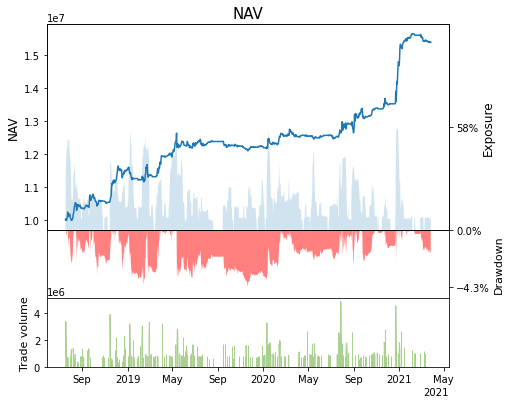

In [10]:
#nav_df.to_csv(directory+'nav_df.csv')
evaluator.show_summary()

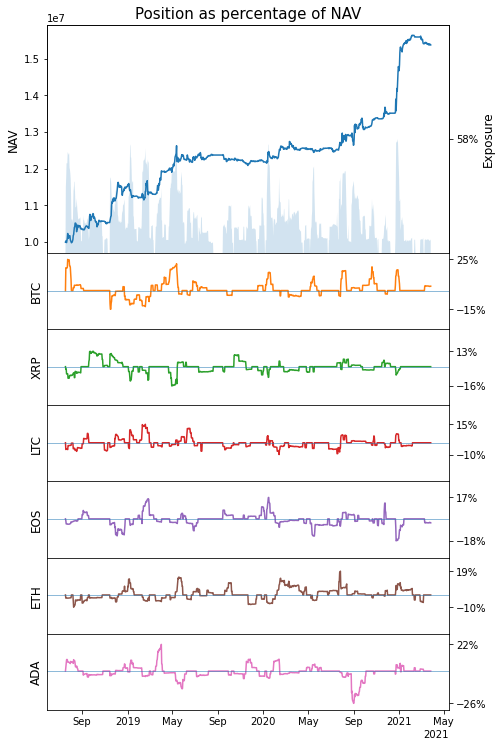

In [11]:
evaluator.show_position()

In [12]:
evaluator.trade_summary_df

,Number of Trades,Avg Profit (Before trading costs) (in %),Avg Holding Period (Days)
Pair,,,
BTC XRP,11.0,7.120817,15.181818
BTC LTC,11.0,2.688260,16.545455
BTC EOS,8.0,7.287440,14.875000
BTC ETH,17.0,3.733246,14.588235
BTC ADA,11.0,7.625116,16.272727
XRP LTC,12.0,-0.057898,9.833333
XRP EOS,8.0,6.459489,8.875000
XRP ETH,8.0,3.826125,23.750000
XRP ADA,11.0,10.081196,21.363636


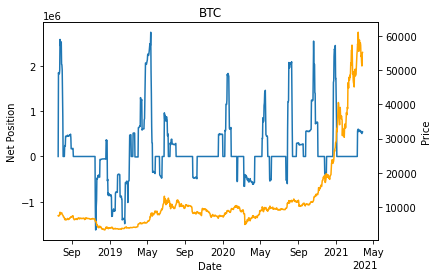

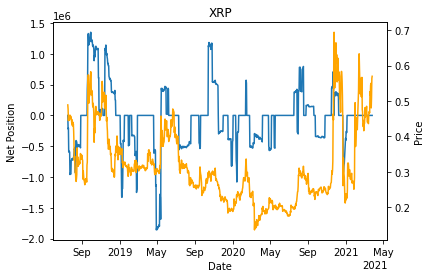

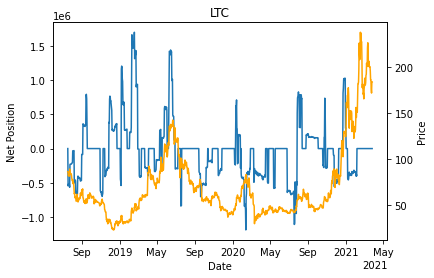

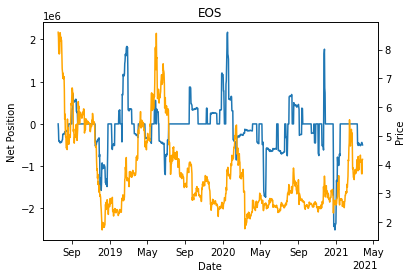

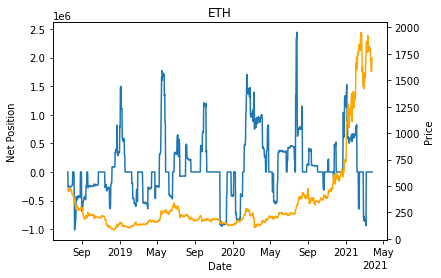

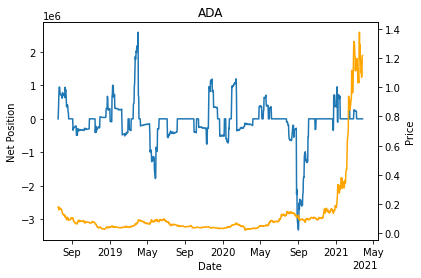

In [13]:
evaluator.show_position_vs_price()

In [19]:
evaluator.symbols

['BTC', 'XRP', 'LTC', 'EOS', 'ETH', 'ADA']

In [18]:
evaluator.strats[0].datas[0].volume.array

array('d', [1178.07, 371.15, 463.54, 685.12, 939.91, 980.5, 770.46, 563.36, 225.76, 347.47, 593.15, 594.12, 790.13, 550.18, 554.18, 888.18, 666.62, 1309.91, 1175.2, 779.5, 481.83, 1108.34, 658.59, 648.94, 685.57, 873.9, 901.25, 1642.54, 1949.32, 1280.1, 676.16, 1027.67, 898.81, 719.59, 971.06, 833.3, 747.79, 659.82, 720.64, 523.31, 625.3, 839.55, 1561.22, 705.52, 724.9, 634.55, 1070.97, 859.82, 760.44, 502.17, 288.14, 504.13, 639.27, 1036.4, 736.72, 1267.18, 1865.9, 966.19, 1329.45, 1516.11, 1422.23, 2295.6, 1869.04, 1930.56, 1650.65, 1347.95, 1788.86, 2555.89, 2256.1, 1959.75, 1394.13, 1269.38, 1783.44, 1467.03, 1498.91, 1659.85, 2459.59, 1857.73, 1385.7, 1192.58, 1741.45, 1421.75, 2726.84, 1893.28, 3186.23, 2685.67, 4854.44, 2543.41, 1228.66, 1745.83, 2294.2, 3893.14, 3912.88, 3845.99, 3857.0, 4468.09, 3518.81, 4054.54, 4331.83, 4228.66, 4108.18, 4473.98, 4877.07, 13041.92, 9181.76, 6033.85, 4700.93, 5212.23, 4599.15, 5510.92, 6556.68, 7262.95, 17344.04, 13725.0, 16107.43, 11632.79, 

In [14]:
#sharpe_df, calmar_df = sentivity_analysis(0.5,0.625,0.025,1,2.25,0.25)
#sharpe_df.to_csv(directory+'sharpe.csv')
#calmar_df.to_csv(directory+'calmar.csv')
#gen_heatmap(sharpe_df, 'Sharpe Ratio','Hurst Min','Power Stat', 1.2, 2.15)
#gen_heatmap(calmar_df, 'Calmar Ratio','Hurst Min','Power Stat', 1.5, 4.5)